# Tutorial 00: Quick start

## 1. import libraries

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import warnings
warnings.filterwarnings('ignore')

## 2. Problem definition
Let's get started with the toy example of two-dimensional Branin function.<br>
More details can be found [here](https://www.sfu.ca/~ssurjano/branin.html)<br>
- bounds: -2 from 3
- variable type: continuous
- ground truth X: [-1.02543108, -1.02543108]
- ground truth Y: 10.6043
- optimisation: maximisation

In [2]:
import torch
def BraninFunction(x):
    x = torch.atleast_2d(x)
    return ((x.sin() + (3*x).cos()/2).square() / ((x/2).square()+0.3)).prod(axis=1)

# set bounds
bounds = torch.tensor([
    [-2,-2], # lower bound 
    [ 3, 3], # upper bound
])

# set prior
from SOBER._prior import Uniform    # Import prior from SOBER libraries
prior = Uniform(bounds)

### 2.1 Initial sampling

In [3]:
n_init = 10          # number of initial samples
random_seed = 50     # random seed that determines random behaviours
torch.manual_seed(random_seed)

X = prior.sample(n_init) # random samples
Y = BraninFunction(X).unsqueeze(-1)

### 2.2 Gaussian process modelling

In [4]:
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
model = SingleTaskGP(X, Y) # setting GP model
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll) # optimize GP hyperparameters

from SOBER._sober import Sober
sober = Sober(prior, model) # set SOBER wrapper

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


### 2.3 Set experimental conditions

In [5]:
batch_size = 30    # number of batch samples
n_rec = 20000      # number of candidates sampled from pi
n_nys = 500        # number of samples for Nyström approximation
n_init = 10        # number of initial samples
n_iterations = 5   # number of iterations (batches)
obj = None         # acquisition function

### 2.4 Run!

In [6]:
import time
results = []
for n_iter in range(n_iterations):
    start = time.monotonic()
    model = SingleTaskGP(X, Y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    sober.update_model(model)     # pass the updated model to sober
    X_batch = sober.next_batch(
        n_rec,
        n_nys,
        batch_size,
        calc_obj=obj,
        verbose=False,
    )
    end = time.monotonic()
    interval = end - start
    
    Y_batch = BraninFunction(X_batch).unsqueeze(-1)
    X = torch.cat((X, X_batch), dim=0)
    Y = torch.cat((Y, Y_batch), dim=0)

    print(f"{len(X)}) Best value: {Y.max().item():.5e}")
    print(f"Acquisition time [s]: {interval:.5e}, per sample [ms]: {interval/batch_size*1e3:.5e}")
    results.append([interval, Y.max().item()])

40) Best value: 1.00283e+01
Acquisition time [s]: 5.15311e+00, per sample [ms]: 1.71770e+02
70) Best value: 1.05872e+01
Acquisition time [s]: 7.49037e+00, per sample [ms]: 2.49679e+02
100) Best value: 1.06037e+01
Acquisition time [s]: 4.89817e+00, per sample [ms]: 1.63272e+02
130) Best value: 1.06042e+01
Acquisition time [s]: 5.05372e+00, per sample [ms]: 1.68457e+02
160) Best value: 1.06043e+01
Acquisition time [s]: 8.56311e+00, per sample [ms]: 2.85437e+02


### 2.5 Check convergence

Text(0, 0.5, 'overhead [s]')

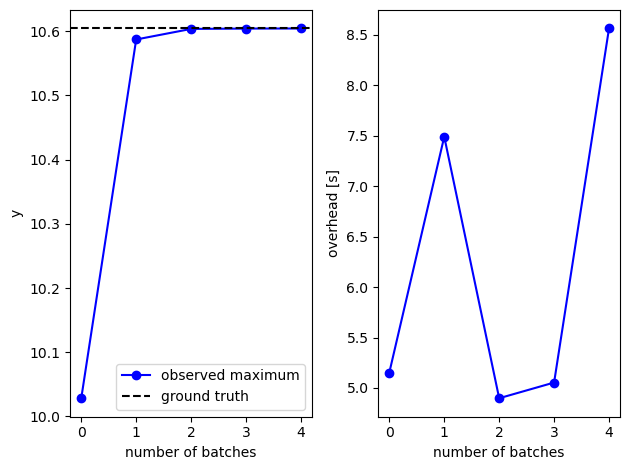

In [7]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True)
idx_batch = torch.arange(n_iterations)
results = torch.tensor(results)
ytrue = 10.604333877563477
ax1.plot(idx_batch, results[:,1], 'bo-', label="observed maximum")
ax1.axhline(y=ytrue, linestyle="--", color="k", label="ground truth")
ax1.legend()
ax1.set_xlabel("number of batches")
ax1.set_ylabel("y")

ax2.plot(idx_batch, results[:,0], 'bo-')
ax2.set_xlabel("number of batches")
ax2.set_ylabel("overhead [s]")